In [ ]:
import os
import sys

# ==========================================
# Environment Setup: Automatic Detection
# ==========================================
try:
    # Check if running in Google Colab
    from google.colab import drive
    print("🚀 Running in Google Colab")

    # 1. Mount Google Drive
    drive.mount('/content/drive')

    # 2. Change working directory to the project folder in Google Drive
    colab_path = 'Please write your Google Drive path here.'

    if os.path.exists(colab_path):
        os.chdir(colab_path)
        print(f"📂 Current Directory moved to: {os.getcwd()}")
    else:
        print(f"⚠️ Path not found: {colab_path}")

except ImportError:
    # Running Locally
    print("💻 Running Locally")

    # Identify the project root directory regardless of the notebook location.
    # If the current directory is 'notebooks', move up one level to the project root.
    if os.path.basename(os.getcwd()) == "notebooks":
        os.chdir("..")
        print("⬆️ Moved up from 'notebooks' folder to project root.")

    print(f"📂 Current Directory: {os.getcwd()}")

# ==========================================
# Add Project Root to Path & Import Utils
# ==========================================
# Ensure the root directory is in sys.path to find EN_soccer_utils.py
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

import EN_soccer_utils as utils
print("✅ Successfully imported EN_soccer_utils")

🚀 Running in Google Colab
Mounted at /content/drive
📂 Current Directory moved to: /content/drive/MyDrive/データサイエンス個人学習/Football_Tactical_Analysis
✅ Successfully imported EN_soccer_utils


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image, display

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold


from sklearn.preprocessing import StandardScaler

import datetime as dt
import os
import pickle
import time
import glob
from shapely.geometry import Point, Polygon # 幾何学計算用
import ast
import sys
import importlib


from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
import shap


import xgboost as xgb
from sklearn.linear_model import LogisticRegression


try:
    import optuna
except ImportError:
    !pip install optuna
    import optuna


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 14.4 MB/s eta 0:00:00


In [ ]:
# If you have just modified utils.py, run this to reload it
importlib.reload(utils)

<module 'EN_soccer_utils' from '/content/drive/MyDrive/データサイエンス個人学習/Football_Tactical_Analysis/EN_soccer_utils.py'>

# Tuning and Save Settings

In [ ]:
# Set the experiment name for saving results
EXP_NAME = "version_with_all_features"

LR_NAME = "LogisticRegression_" + EXP_NAME
LR_TUNED_NAME = "LogisticRegression_Tuned_" + EXP_NAME

XGB_NAME = "XGBoost_" + EXP_NAME
XGB_TUNED_NAME = "XGBoost_Tuned_" + EXP_NAME

ENSEMBLE_NAME = "Ensemble_" + EXP_NAME

# Whether to perform tuning for Logistic Regression and XGBoost
lr_tuning = True
xgb_tuning = True

# Settings for whether to save experiment results
lr_save = False
lr_tuned_save = True
xgb_save = True
xgb_tuned_save = True
ensemble_save = True
best_model_save = True

# Load dataset

In [ ]:
# Load CSV
all_league_shots_df = pd.read_csv("data/all_league_shots_2015_16_with_assist.csv")

In [ ]:
df = all_league_shots_df.copy()

df["match_id"].head()

# Apply preprocessing and feature engineering

# Apply functions from utils (a custom library containing various utility functions)
df = utils.preprocess_pipeline(df)



🥶 Calculating Freeze Frame features (Universal fixed version)...


/content/drive/MyDrive/データサイエンス個人学習/Football_Tactical_Analysis/EN_soccer_utils.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["under_pressure"] = df["under_pressure"].fillna(False).astype(int)


# Preparation for Cross-Validation

Define common settings for all cross-validations within this notebook here.



In [ ]:
# Reserve match_id as "groups" before creating the feature matrix X
# This group variable will be used later for data splitting during cross-validation
groups = df["match_id"]

# Standardize CV settings here since multiple models will undergo CV
# StratifiedGroupKFold: Splits data by match while maintaining a balanced goal ratio
# Using 5-fold for final evaluation, and 3-fold for tuning to save time


# For final evaluation
cv_strategy = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# For tuning
cv_tuning = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

print("✅ CV Strategies Ready (Main: 5-fold, Tuning: 3-fold)")



✅ CV Strategies Ready (Main: 5-fold, Tuning: 3-fold)


# Feature Selection



In [ ]:
# Various feature sets
BASE_FEATURES = ["shot_distance", "shot_angle"]
CONTEXT_FEATURES = [c for c in df.columns if c.startswith(("under_pressure", "body_", "shoot_type_", "pattern_","shoot_technic_"))]
ADVANCED_GEOMETRY_FEATURES = ["effective_goal_width", "angle_from_center","in_penalty_area","in_six_yard_box","distance_angle_interaction","distance_squared"]
ASSIST_FEATURES = ["has_assist","pass_length","pass_progress_x","is_cross", "is_cutback", "is_through_ball","is_pass_ground","is_pass_high","is_pass_low"]
SHOOT_BLOCK_FEATURES = ["gk_distance_to_shooter","num_opponents_in_shot_cone","num_teammates_in_shot_cone","total_players_in_shot_cone"]



In [ ]:
FEATURES = BASE_FEATURES + CONTEXT_FEATURES + ADVANCED_GEOMETRY_FEATURES + ASSIST_FEATURES + SHOOT_BLOCK_FEATURES



In [ ]:
TARGET = "is_goal"



In [ ]:
X = df[FEATURES]
y = df[TARGET]

mask = X.notnull().all(axis=1)
X = X[mask]
y = y[mask]

# Logistic Regression Model

## Data Splitting




In [ ]:
shots_eval = df.loc[X.index].copy()

X_train, X_test, y_train, y_test, shots_train, shots_test = train_test_split(
    X, y, shots_eval,
    test_size=0.3,
    random_state=42,
    stratify=y
)



## Model Training



In [ ]:
def run_xg_experiment(
    shots_train,
    shots_test,
    y_train,
    y_test,
    feature_cols,
    results
):
    # ===== Feature Extraction =====
    X_train = shots_train[feature_cols]
    X_test  = shots_test[feature_cols]

    # Exclude missing values (safety measure)
    train_mask = X_train.notnull().all(axis=1)
    test_mask  = X_test.notnull().all(axis=1)

    X_train = X_train[train_mask]
    y_train = y_train[train_mask]

    X_test = X_test[test_mask]
    y_test = y_test[test_mask]

    # ===== Standardization =====
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # ===== Training =====
    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)

    # ===== Prediction =====
    xg_pred = model.predict_proba(X_test_scaled)[:, 1]

    # ===== Evaluation =====
    brier = np.mean((xg_pred - y_test) ** 2)
    ll = log_loss(y_test, xg_pred)

    # ===== Save Results =====
    results.append({
        "feature_cols": feature_cols.copy(),
        "n_features": len(feature_cols),
        "n_train": len(y_train),
        "n_test": len(y_test),
        "brier": brier,
        "log_loss": ll
    })

    return model, scaler, xg_pred, brier, ll



In [ ]:
results = []

model_lr, scaler_lr, xg_pred_lr, brier_lr, ll_lr = run_xg_experiment(
                                      shots_train = shots_train,
                                      shots_test = shots_test,
                                      y_train = y_train,
                                      y_test = y_test,
                                      feature_cols = FEATURES,
                                      results = results
                                  )



In [ ]:
results_df = pd.DataFrame(results)
results_df



,feature_cols,n_features,n_train,n_test,brier,log_loss
0,"[shot_distance, shot_angle, under_pressure, body_Head, body_Left Foot, body_Other, body_Right Foot, shoot_type_Corner, shoot_type_Free Kick, shoot_type_Open Play, pattern_From Corner, pattern_From Counter, pattern_From Free Kick, pattern_From Goal Kick, pattern_From Keeper, pattern_From Kick Off, pattern_From Throw In, pattern_Other, pattern_Regular Play, shoot_technic_Backheel, shoot_technic_Diving Header, shoot_technic_Half Volley, shoot_technic_Lob, shoot_technic_Normal, shoot_technic_Overhead Kick, shoot_technic_Volley, effective_goal_width, angle_from_center, in_penalty_area, in_six_yard_box, distance_angle_interaction, distance_squared, has_assist, pass_length, pass_progress_x, is_cross, is_cutback, is_through_ball, is_pass_ground, is_pass_high, is_pass_low, gk_distance_to_shooter, num_opponents_in_shot_cone, num_teammates_in_shot_cone, total_players_in_shot_cone]",45,6871,2946,0.072974,0.257529


In [ ]:
## Coefficient Visualization

# Store coefficients for each feature in a dataframe
coef_df_lr = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model_lr.coef_[0]
})

coef_df_lr

,feature,coefficient
0,shot_distance,-0.944960
1,shot_angle,0.129599
2,under_pressure,-0.092418
3,body_Head,-0.307520
4,body_Left Foot,0.103290
5,body_Other,0.037906
6,body_Right Foot,0.129010
7,shoot_type_Corner,0.000000
8,shoot_type_Free Kick,0.166343
9,shoot_type_Open Play,-0.166343


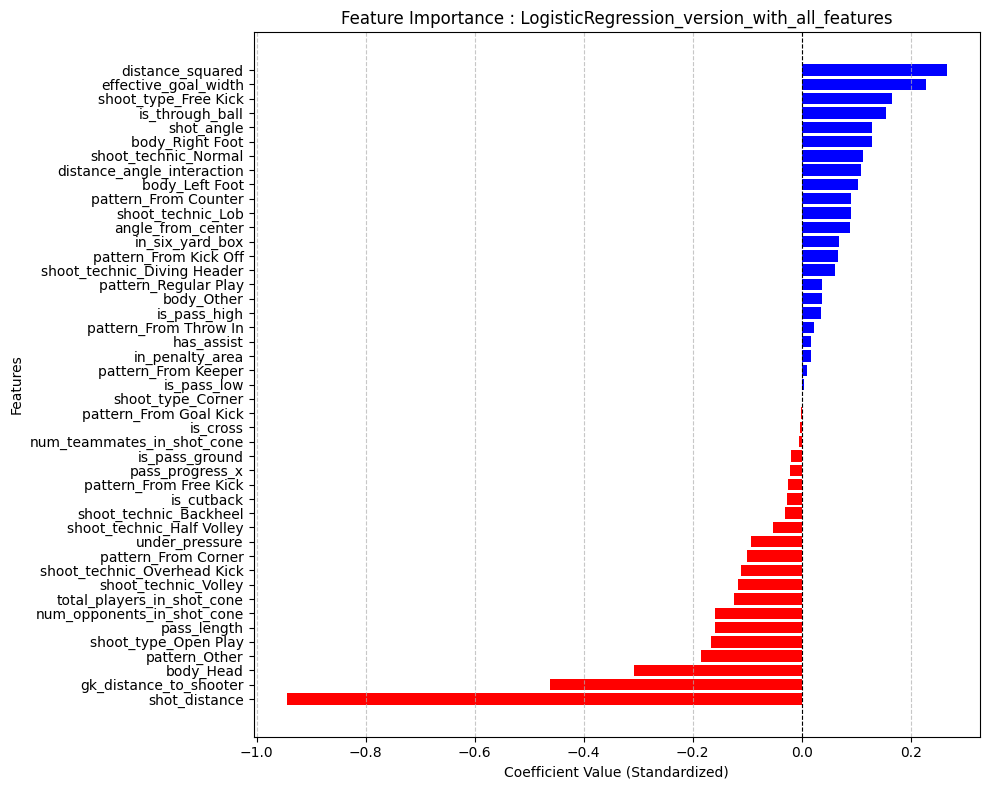

In [ ]:
def plot_feature_importance(coef_df, exp_name):
    # Sort by coefficient
    coef_df['abs_coef'] = coef_df['coefficient'].abs()
    coef_df = coef_df.sort_values(by="coefficient", ascending=True)

    plt.figure(figsize=(10, 8))
    # Use blue for positive coefficients and red for negative
    colors = ['red' if x < 0 else 'blue' for x in coef_df['coefficient']]

    plt.barh(coef_df['feature'], coef_df['coefficient'], color=colors)
    plt.axvline(0, color='black', linewidth=0.8, linestyle='--')

    plt.xlabel("Coefficient Value (Standardized)")
    plt.ylabel("Features")
    plt.title(f"Feature Importance : {exp_name}")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # For saving
    # plt.savefig(f"coef_importance_{exp_name}.png")
    plt.show()

plot_feature_importance(coef_df_lr, LR_NAME)



In [ ]:
# Add the expected values of the test data back to the dataframe containing all test features
shots_test["xg_custom"] = xg_pred_lr

# Compare statistics between existing xG values and custom xG values
# Verify there is no extreme deviation from existing data
shots_test[["shot_statsbomb_xg", "xg_custom"]].describe()



,shot_statsbomb_xg,xg_custom
count,2946.000000,2946.000000
mean,0.091486,0.092425
std,0.118041,0.107276
min,0.000180,0.000093
25%,0.028419,0.027708
50%,0.051349,0.055254
75%,0.100646,0.110808
max,0.995122,0.937823


In [ ]:
# Compare existing xG and custom xG values
shots_test[["shot_statsbomb_xg", "xg_custom"]].head()



,shot_statsbomb_xg,xg_custom
5537,0.071198,0.067456
1602,0.022703,0.026839
4419,0.012131,0.032231
4842,0.035722,0.019670
7895,0.015999,0.010997


In [ ]:
shots_test.groupby("is_goal")[["shot_statsbomb_xg", "xg_custom"]].mean()



,shot_statsbomb_xg,xg_custom
is_goal,,
0,0.075704,0.079808
1,0.245383,0.215465


## Brier Score & Log Loss



In [ ]:
brier_statsbomb = np.mean((shots_test["shot_statsbomb_xg"] - y_test)**2)
ll_statsbomb = log_loss(y_test, shots_test["shot_statsbomb_xg"])

print("           |     custom_score     |  statsbomb_score")
print("-----------------------------------------------------")
print(f"brier_score| {brier_lr} | {brier_statsbomb}")
print("-----------------------------------------------------")
print(f"log_loss   | {ll_lr} | {ll_statsbomb}")

           |     custom_score     |  statsbomb_score
-----------------------------------------------------
brier_score| 0.07297438050086606 | 0.06966115174111573
-----------------------------------------------------
log_loss   | 0.2575286664773782 | 0.24951881740351864


## Correlation on Test Data



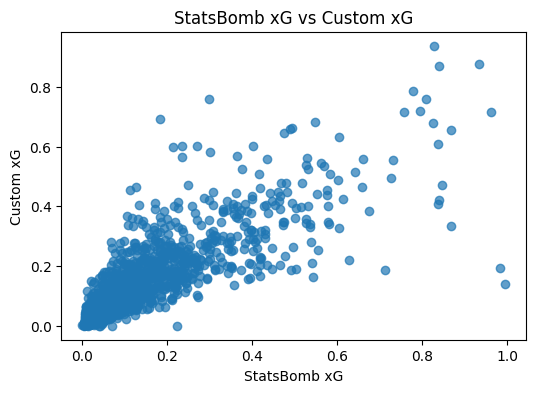

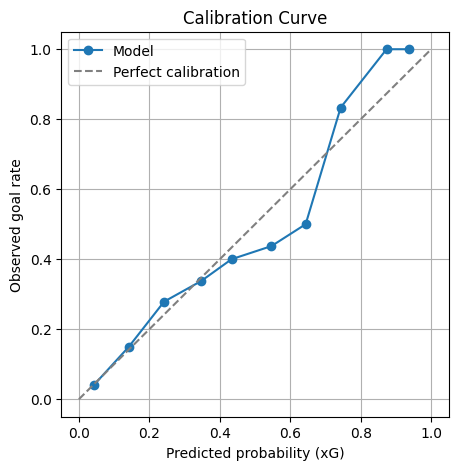

In [ ]:
shots_test[["shot_statsbomb_xg", "xg_custom"]].corr()

# Visualize the degree of correlation by plotting existing xG and custom xG on the X and Y axes
plt.figure(figsize=(6,4))
plt.scatter(
    shots_test["shot_statsbomb_xg"],
    shots_test["xg_custom"],
    alpha=0.7
)

plt.xlabel("StatsBomb xG")
plt.ylabel("Custom xG")
plt.title("StatsBomb xG vs Custom xG")
plt.show()

## Calibration Curve

prob_true_lr, prob_pred_lr = calibration_curve(
    y_test,
    xg_pred_lr,
    n_bins=10,
    strategy="uniform"
)

plt.figure(figsize=(5,5))
plt.plot(prob_pred_lr, prob_true_lr, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")

plt.xlabel("Predicted probability (xG)")
plt.ylabel("Observed goal rate")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()



## Save Results



In [ ]:
if lr_save:
    # Save the experiment results
    utils.save_experiment(
        exp_name = LR_NAME,
        features = FEATURES,
        results_df = results_df,
        coef_df = coef_df_lr,
        brier_custom = brier_lr,
        logloss_custom = ll_lr,
        y_test = y_test,
        xg_pred = xg_pred_lr
        )

# Logistic Regression Model Hyperparameter Tuning



## Hyperparameter Tuning




In [ ]:
def objective_lr_full(trial):
    """
    Optuna objective function for Logistic Regression (Full search version)
    """
    # --- Parameter Search Range ---

    # Regularization type
    # Excluded 'none' as it is prone to overfitting; focusing primarily on ElasticNet
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    C = trial.suggest_float('C', 1e-4, 100.0, log=True)

    # Search for l1_ratio (mixing ratio of L1 and L2) only for ElasticNet
    # 0=L2, 1=L1, 0.5=half-and-half
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    else:
        l1_ratio = None

    # Class weighting (adjustment for imbalanced data)
    # None=Equal, 'balanced'=Automatically increase weight for minority class (goals)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])


    # Create parameter dictionary
    params = {
        'solver': 'saga',        # General-purpose solver compatible with elasticnet and l1 (slower)
        'penalty': penalty,
        'C': C,
        'class_weight': class_weight,
        'l1_ratio': l1_ratio,    # Ignored if not elasticnet, but passing it won't cause an error
        'max_iter': 5000,        # Increase iterations as saga takes time to converge
        'random_state': 42,
        'n_jobs': -1             # Parallel processing
    }

    # --- Cross-Validation (3-Fold) ---
    cv_log_losses = []

    # Pass groups=groups to split()
    # (groups, X, and y refer to global variables defined outside the function)
    for train_idx, val_idx in cv_tuning.split(X, y, groups=groups):

        # Data splitting
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Standardization
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # Model definition and training
        model = LogisticRegression(**params)
        model.fit(X_train_scaled, y_train)

        # Prediction
        preds = model.predict_proba(X_val_scaled)[:, 1]

        # Evaluation (Log Loss)
        loss = log_loss(y_val, preds)
        cv_log_losses.append(loss)

    return np.mean(cv_log_losses)



In [ ]:
# Directory for saving results
save_dir = "parameters"
os.makedirs(save_dir, exist_ok=True)

if lr_tuning:
  print("🚀 Starting full search for Logistic Regression (including ElasticNet)...")
  print("⏳ This will take time as it uses solver='saga'.")

  # Execute optimization
  study_lr_tuned = optuna.create_study(direction='minimize')

  # Increased n_trials to 100 due to more parameter combinations
  study_lr_tuned.optimize(objective_lr_full, n_trials=100)

  print("\n" + "="*30)
  print("🏆 LR(Full) Best Parameters:")
  print(study_lr_tuned.best_params)
  print(f"🏆 LR(Full) Best CV Log Loss: {study_lr_tuned.best_value:.5f}")
  print("="*30)

  # =================================================
  # Save Best Parameters
  # =================================================

  best_params_lr = study_lr_tuned.best_params

  # Add fixed parameters
  best_params_lr['solver'] = 'saga'
  best_params_lr['max_iter'] = 5000
  best_params_lr['random_state'] = 42
  best_params_lr['n_jobs'] = -1

  # If elasticnet wasn't selected, l1_ratio might be missing; fill it (None is OK)
  if 'l1_ratio' not in best_params_lr:
      best_params_lr['l1_ratio'] = None


  print("🏆 Logistic Regression Best Params:", best_params_lr)

  with open(os.path.join(save_dir, "best_params_lr.json"), "w") as f:
      json.dump(best_params_lr, f, indent=4)

  print("✅ Saved Logistic Regression parameters")

else:
  # ------------------------------------------------
  # Load Logistic Regression parameters (skipping tuning)
  # ------------------------------------------------
  lr_json_path = os.path.join(save_dir, "best_params_lr.json")

  if os.path.exists(lr_json_path):
      with open(lr_json_path, "r") as f:
          best_params_lr = json.load(f)
      print("✅ Loaded LR parameters:", best_params_lr)
  else:
      print("⚠️ Parameter file not found")



[I 2026-01-17 06:38:50,949] A new study created in memory with name: no-name-abc2e994-190c-498c-9062-593ccc08a9b5


🚀 Starting full search for Logistic Regression (including ElasticNet)...
⏳ This will take time as it uses solver='saga'.


[I 2026-01-17 06:38:51,586] Trial 0 finished with value: 0.5602483171162681 and parameters: {'penalty': 'l2', 'C': 0.0017755885414194044, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5602483171162681.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2026-01-17 06:39:20,348] Trial 1 finished with value: 0.5542963598381526 and parameters: {'penalty': 'elasticnet', 'C': 0.19163729586956654, 'l1_ratio': 0.6691826088379769, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5542963598381526.
[I 2026-01-17 06:39:22,609] Trial 2 finished with value: 0.2661592422996188 and parameters: {'penalty': 'l1', 'C': 0.02063212898880312, 'class_weight': None}. Best is trial 2 with value: 0.2661592422996188.
[I 2026-01-17 06:39:25,674] Trial 3 finished with value: 0.5557920445983574 and parameters: {'penalty': 'elasticnet', 'C': 0.0059724824325137794, 'l1_


🏆 LR(Full) Best Parameters:
{'penalty': 'l1', 'C': 0.1553659150922986, 'class_weight': None}
🏆 LR(Full) Best CV Log Loss: 0.26124
🏆 Logistic Regression Best Params: {'penalty': 'l1', 'C': 0.1553659150922986, 'class_weight': None, 'solver': 'saga', 'max_iter': 5000, 'random_state': 42, 'n_jobs': -1, 'l1_ratio': None}
✅ Saved Logistic Regression parameters


## Retraining with Best Parameters



In [ ]:
# For storing results
oof_preds_lr_tuned = np.zeros(len(X))
coefs_list = []

print(f"\n🚀 Logistic Regression Group CV Running...")

# Passing groups=groups splits the data into train/val by match_id
# This prevents shots from the same match appearing in both sets, avoiding data leakage
for fold, (train_idx, val_idx) in enumerate(cv_strategy.split(X, y, groups=groups)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Training
    model_lr_tuned = LogisticRegression(**best_params_lr)
    model_lr_tuned.fit(X_train_scaled, y_train)

    # Prediction
    pred_probs = model_lr_tuned.predict_proba(X_val_scaled)[:, 1]
    oof_preds_lr_tuned[val_idx] = pred_probs

    # Save coefficients
    coefs_list.append(model_lr_tuned.coef_[0])

# Overall scores
brier_lr_tuned = np.mean((oof_preds_lr_tuned- y) ** 2)
ll_lr_tuned = log_loss(y, oof_preds_lr_tuned)

print(f"LR Results - Brier: {brier_lr_tuned:.5f}, LogLoss: {ll_lr_tuned:.5f}")




🚀 Logistic Regression Group CV Running...
LR Results - Brier: 0.07352, LogLoss: 0.26117


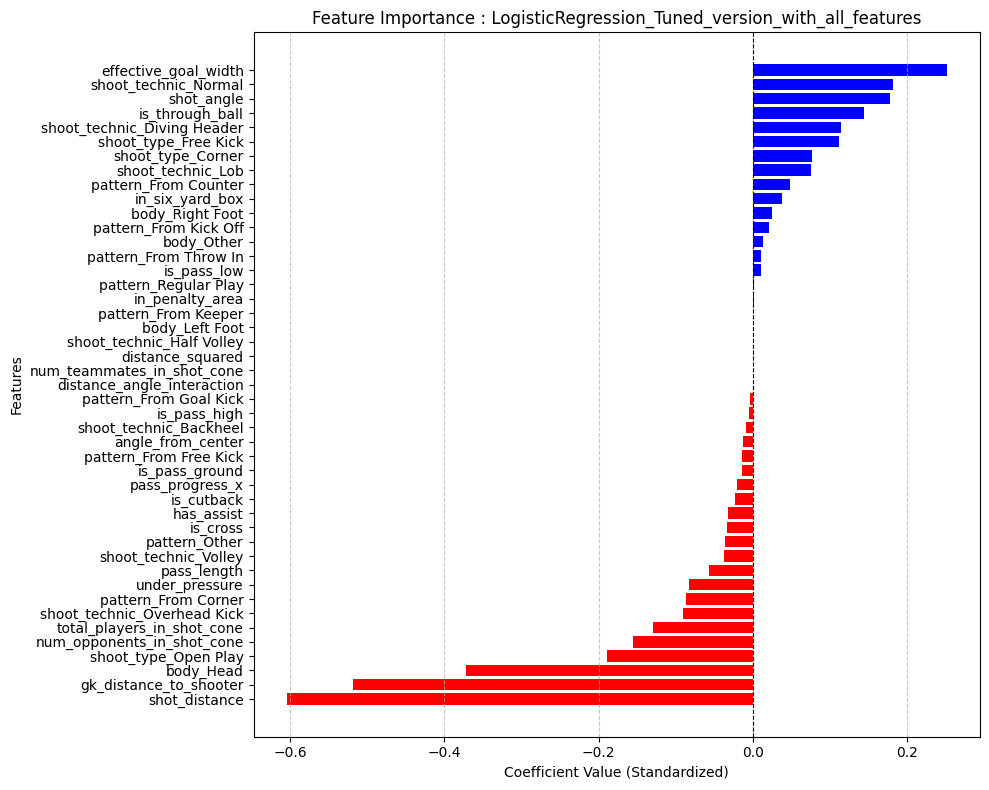

In [ ]:
## Coefficient Visualization

# --- Visualize Coefficients ---
mean_coefs_lr_tuned = np.mean(coefs_list, axis=0)
coef_df_lr_tuned = pd.DataFrame({
    "feature": FEATURES,
    "coefficient": mean_coefs_lr_tuned
})
plot_feature_importance(coef_df_lr_tuned, LR_TUNED_NAME)



## Brier Score & LogLoss



In [ ]:
print("\n" + "="*30)
print(f"Logistic Regression (ElasticNet) Final Results:")
print(f"Brier Score: {brier_lr_tuned:.5f}")
print(f"Log Loss   : {ll_lr_tuned:.5f}")
print("="*30)




Logistic Regression (ElasticNet) Final Results:
Brier Score: 0.07352
Log Loss   : 0.26117


## Calibration Curve



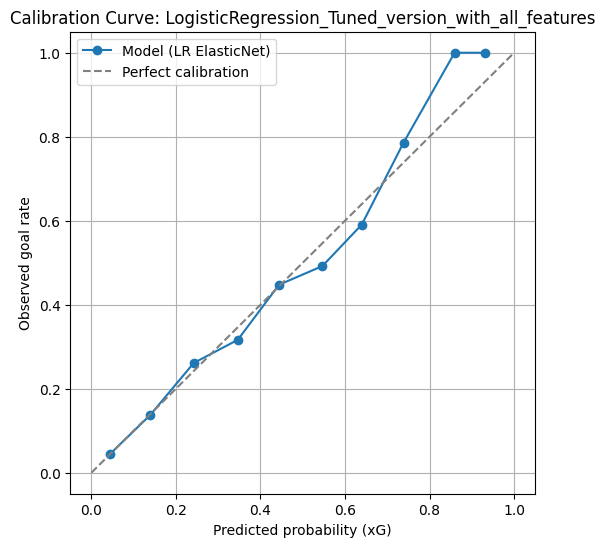

In [ ]:
# --- Calibration Curve ---
prob_true, prob_pred = calibration_curve(y, oof_preds_lr_tuned, n_bins=10, strategy="uniform")

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Model (LR ElasticNet)")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")
plt.xlabel("Predicted probability (xG)")
plt.ylabel("Observed goal rate")
plt.title(f"Calibration Curve: {LR_TUNED_NAME}")
plt.legend()
plt.grid(True)
plt.show()



## Save Results



In [ ]:
if lr_tuned_save:
    # --- Save Results ---
    utils.save_experiment(
        exp_name=LR_TUNED_NAME,
        features=FEATURES,
        results_df=pd.DataFrame([{"brier": brier_lr_tuned, "log_loss": ll_lr_tuned}]),
        coef_df=coef_df_lr_tuned,
        brier_custom=brier_lr_tuned,
        logloss_custom=ll_lr_tuned,
        y_test=y,
        xg_pred=oof_preds_lr_tuned
    )

✅ Experiment saved to: experiments/LogisticRegression_Tuned_version_with_all_features_20260117_070224
📊 Figures saved: calibration_curve.png, feature_importance.png


# XGBoost Model



## Data Preparation




In [ ]:
# Preparation of data and features

X = df[FEATURES].copy()
y = df[TARGET].copy()



## Cross-Validation Awareness



In [ ]:
print("🚀 Stratified Group K-Fold (Match-based) Running...")

# For storing results
oof_preds_xgb = np.zeros(len(X))
models = []
importances = []

# Use cv_strategy and pass groups
for fold, (train_index, val_index) in enumerate(cv_strategy.split(X, y, groups=groups)):

    # Split
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Model definition
    model = xgb.XGBClassifier(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=4,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        eval_metric='logloss',
        early_stopping_rounds=50
    )

    # Training
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Prediction
    xg_pred = model.predict_proba(X_val)[:, 1]

    # Storage
    oof_preds_xgb[val_index] = xg_pred
    models.append(model)
    importances.append(model.feature_importances_)

    # Score calculation
    fold_brier = np.mean((xg_pred - y_val) ** 2)
    fold_ll = log_loss(y_val, xg_pred)
    print(f"Fold {fold+1}/5 - Brier: {fold_brier:.5f}, LogLoss: {fold_ll:.5f}")

print("\n✅ Baseline CV Complete")



🚀 Stratified Group K-Fold (Match-based) Running...
Fold 1/5 - Brier: 0.07008, LogLoss: 0.25092
Fold 2/5 - Brier: 0.07289, LogLoss: 0.25988
Fold 3/5 - Brier: 0.07392, LogLoss: 0.26608
Fold 4/5 - Brier: 0.07594, LogLoss: 0.26409
Fold 5/5 - Brier: 0.07620, LogLoss: 0.26756

✅ Baseline CV Complete


In [ ]:
# Overall evaluation
brier_xgb = np.mean((oof_preds_xgb - y) ** 2)
ll_xgb = log_loss(y, oof_preds_xgb)

print("\n" + "="*30)
print(f"XGBoost Final Results (CV Average):")
print(f"Brier Score: {brier_xgb:.5f}")
print(f"Log Loss   : {ll_xgb:.5f}")
print("="*30)




XGBoost Final Results (CV Average):
Brier Score: 0.07386
Log Loss   : 0.26187


In [ ]:
## Feature Importance

# Calculate mean feature importance
mean_importance = np.mean(importances, axis=0)

coef_df_xgb = pd.DataFrame({"feature": FEATURES, "coefficient": mean_importance}).sort_values(by="coefficient", ascending=False)

coef_df_xgb



,feature,coefficient
41,gk_distance_to_shooter,0.084110
3,body_Head,0.046349
39,is_pass_high,0.040459
31,distance_squared,0.040453
1,shot_angle,0.039962
44,total_players_in_shot_cone,0.038893
37,is_through_ball,0.035848
0,shot_distance,0.034391
10,pattern_From Corner,0.032957
28,in_penalty_area,0.029909


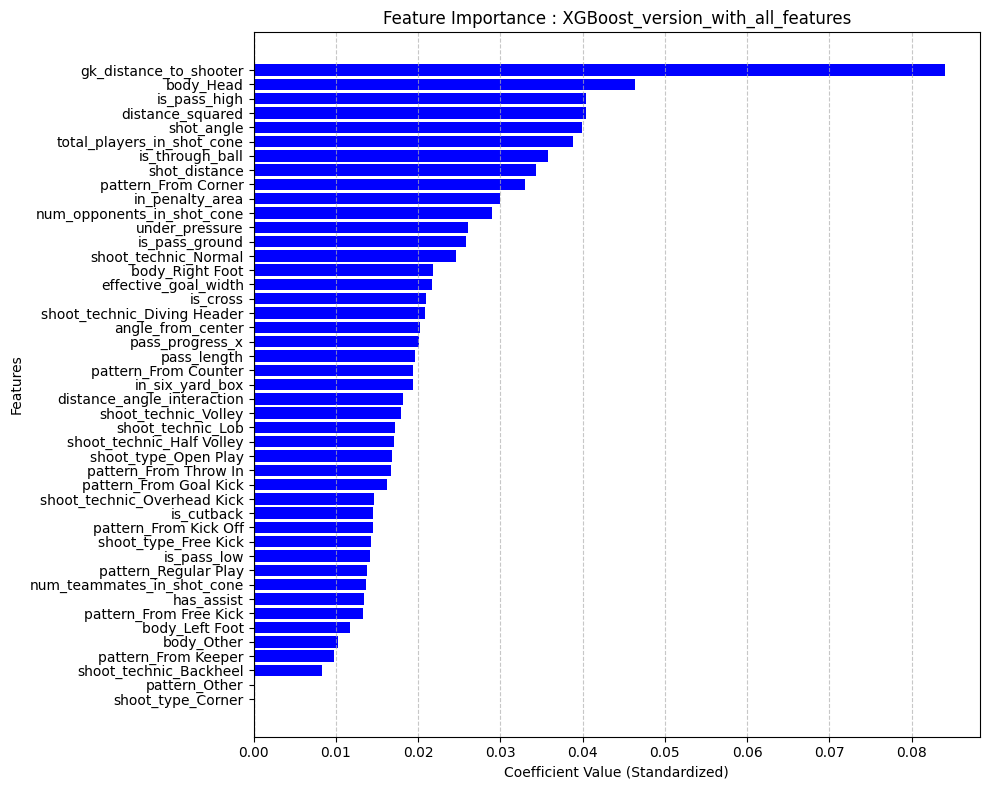

In [ ]:
plot_feature_importance(coef_df_xgb, XGB_NAME)



## Calibration Curve



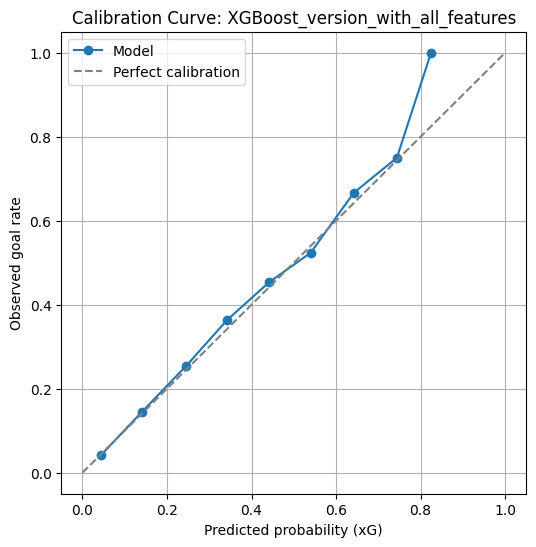

In [ ]:
prob_true, prob_pred = calibration_curve(y, oof_preds_xgb, n_bins=10, strategy="uniform")
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")
plt.xlabel("Predicted probability (xG)")
plt.ylabel("Observed goal rate")
plt.title(f"Calibration Curve: {XGB_NAME}")
plt.legend()
plt.grid(True)
plt.show()



## Save Results



In [ ]:
if xgb_save:
    # Save
    # Uses save_experiment defined earlier in this notebook
    utils.save_experiment(
        exp_name= XGB_NAME,
        features=FEATURES,
        results_df=pd.DataFrame([{"brier": brier_xgb, "log_loss": ll_xgb}]),
        coef_df=coef_df_xgb,
        brier_custom=brier_xgb,
        logloss_custom=ll_xgb,
        y_test=y,      # All data
        xg_pred=oof_preds_xgb # Predicted values for all data
)

✅ Experiment saved to: experiments/XGBoost_version_with_all_features_20260117_070231
📊 Figures saved: calibration_curve.png, feature_importance.png


# XGBoost Hyperparameter Tuning Version



## Hyperparameter Tuning




In [ ]:
def objective(trial):
    """
    Objective function for Optuna trial (High precision/Long search version)
    """
    # 1. Define the range of parameters to search
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'random_state': 42,

        # Since lower learning rates slow down improvement, avoid stopping too early
        'early_stopping_rounds': 100,

        # --- Tuning Items ---

        # Lower the upper and lower limits of learning rate (0.1 -> 0.05, 0.005 -> 0.001)
        # Forces the selection of "slow and extensive learning" settings
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),

        # Slightly expand the maximum tree depth
        'max_depth': trial.suggest_int('max_depth', 3, 12),

        # Add Gamma (Minimum loss reduction required for a split)
        # Important parameter to prevent the model from becoming overly complex
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),

        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),

        # Set iterations high enough (it will stop via Early Stopping anyway)
        'n_estimators': 20000
    }

    # List to calculate the average CV score
    cv_log_losses = []

    # ★ Pass groups=groups here as well
    for train_idx, val_idx in cv_tuning.split(X, y, groups=groups):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBClassifier(**params)

        model.fit(
            X_train_cv, y_train_cv,
            eval_set=[(X_val_cv, y_val_cv)],
            verbose=False,
        )

        preds = model.predict_proba(X_val_cv)[:, 1]
        loss = log_loss(y_val_cv, preds)
        cv_log_losses.append(loss)

    return np.mean(cv_log_losses)



In [ ]:
# Directory for saving
save_dir = "parameters"
os.makedirs(save_dir, exist_ok=True)


if xgb_tuning:
    print("🚀 Starting Optuna tuning (Extensive version)...")
    print("(This will take longer than the previous run due to the lower learning rate)")

    # Execute optimization
    study_xgb = optuna.create_study(direction='minimize')

    # Increase number of trials (50 -> 100)
    # Increased the search count since the parameter space has expanded
    study_xgb.optimize(objective, n_trials=100)

    print("\n" + "="*30)
    print("🏆 Best Parameters:")
    print(study_xgb.best_params)
    print(f"🏆 Best CV Log Loss: {study_xgb.best_value:.5f}")
    print("="*30)

    # =================================================
    # Save Best Parameters
    # =================================================
    best_params_xgb = study_xgb.best_params
    best_params_xgb['n_estimators'] = 10000
    best_params_xgb['random_state'] = 42
    best_params_xgb['eval_metric'] = 'logloss'
    best_params_xgb['early_stopping_rounds'] = 50


    print("🏆 XGBoost Best Params:", best_params_xgb)

    # Save as JSON file
    with open(os.path.join(save_dir, "best_params_xgb.json"), "w") as f:
        json.dump(best_params_xgb, f, indent=4)

    print("✅ Saved XGBoost parameters")

else:
    # ------------------------------------------------
    # Load XGBoost parameters
    # ------------------------------------------------
    xgb_json_path = os.path.join(save_dir, "best_params_xgb.json")

    if os.path.exists(xgb_json_path):
        with open(xgb_json_path, "r") as f:
            best_params_xgb = json.load(f)
        print("✅ Loaded XGBoost parameters:", best_params_xgb)
    else:
        print("⚠️ Parameter file not found. Please run Optuna.")



[I 2026-01-17 07:02:32,718] A new study created in memory with name: no-name-52a90c83-63f0-4417-ab7c-4ddfdb018666


🚀 Starting Optuna tuning (Extensive version)...
(This will take longer than the previous run due to the lower learning rate)


[I 2026-01-17 07:02:35,135] Trial 0 finished with value: 0.26516218686674115 and parameters: {'learning_rate': 0.010396403859300707, 'max_depth': 7, 'gamma': 0.21674361938672337, 'min_child_weight': 7, 'subsample': 0.6395962966891808, 'colsample_bytree': 0.6136839767742508, 'reg_alpha': 0.0005359253609514754, 'reg_lambda': 0.1084500037629121}. Best is trial 0 with value: 0.26516218686674115.
[I 2026-01-17 07:02:43,278] Trial 1 finished with value: 0.26364857292990035 and parameters: {'learning_rate': 0.006768046882910697, 'max_depth': 9, 'gamma': 4.168857943420715, 'min_child_weight': 3, 'subsample': 0.7436980171665424, 'colsample_bytree': 0.5401714237859674, 'reg_alpha': 2.705288984300506, 'reg_lambda': 1.3304571213138025e-08}. Best is trial 1 with value: 0.26364857292990035.
[I 2026-01-17 07:02:48,083] Trial 2 finished with value: 0.2666043649735324 and parameters: {'learning_rate': 0.0048608208930787464, 'max_depth': 7, 'gamma': 0.7409406202021707, 'min_child_weight': 5, 'subsample'


🏆 Best Parameters:
{'learning_rate': 0.04369579300826802, 'max_depth': 3, 'gamma': 4.289350350114566, 'min_child_weight': 1, 'subsample': 0.853631844847704, 'colsample_bytree': 0.7970895433857448, 'reg_alpha': 3.709845022024343e-08, 'reg_lambda': 6.968639131382597e-06}
🏆 Best CV Log Loss: 0.26160
🏆 XGBoost Best Params: {'learning_rate': 0.04369579300826802, 'max_depth': 3, 'gamma': 4.289350350114566, 'min_child_weight': 1, 'subsample': 0.853631844847704, 'colsample_bytree': 0.7970895433857448, 'reg_alpha': 3.709845022024343e-08, 'reg_lambda': 6.968639131382597e-06, 'n_estimators': 10000, 'random_state': 42, 'eval_metric': 'logloss', 'early_stopping_rounds': 50}
✅ Saved XGBoost parameters


## Retrain Model with Best Parameters



In [ ]:
# ==========================================
# Final Model Validation (Tuned Parameters)
# ==========================================
oof_preds_xgb_tuned = np.zeros(len(X))
print("\n🚀 Best Params Final Group CV Running...")

last_model = None

# Pass groups=groups
for fold, (train_idx, val_idx) in enumerate(cv_strategy.split(X, y, groups=groups)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model_xgb_tuned = xgb.XGBClassifier(**best_params_xgb)

    model_xgb_tuned.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    oof_preds_xgb_tuned[val_idx] = model_xgb_tuned.predict_proba(X_val)[:, 1]
    last_model = model_xgb_tuned

# Final scores
brier_xgb_tuned = np.mean((oof_preds_xgb_tuned - y) ** 2)
ll_xgb_tuned = log_loss(y, oof_preds_xgb_tuned)

print(f"✅ Tuned XGBoost - Brier: {brier_xgb_tuned:.5f}, LogLoss: {ll_xgb_tuned:.5f}")




🚀 Best Params Final Group CV Running...
✅ Tuned XGBoost - Brier: 0.07385, LogLoss: 0.26190


## Brier Score & LogLoss



In [ ]:
print(f"✅ Tuned XGBoost - Brier: {brier_xgb_tuned:.5f}, LogLoss: {ll_xgb_tuned:.5f}")

✅ Tuned XGBoost - Brier: 0.07385, LogLoss: 0.26190


## Feature Importance



In [ ]:
# Save experimental results
importances = last_model.feature_importances_
coef_df_xgb_tuned = pd.DataFrame({"feature": FEATURES, "coefficient": importances})



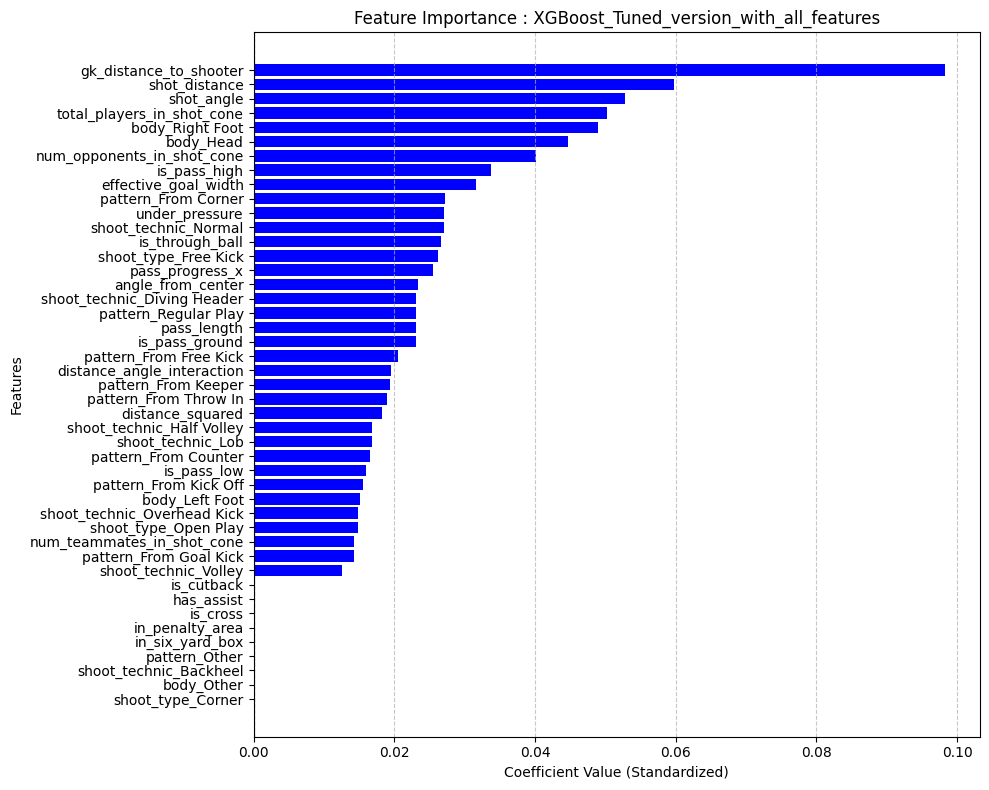

In [ ]:
plot_feature_importance(coef_df_xgb_tuned,XGB_TUNED_NAME)



## Calibration Curve



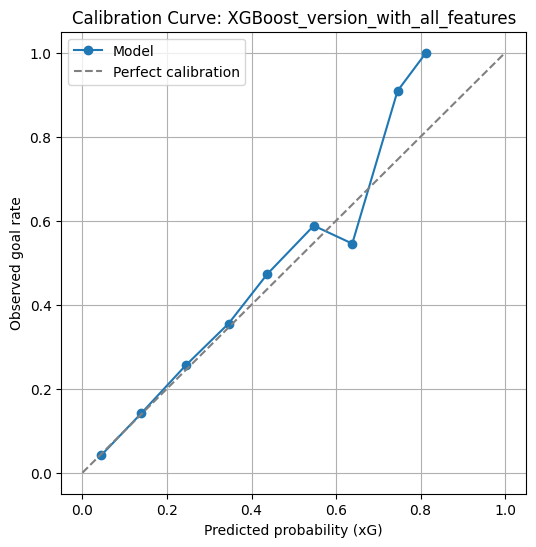

In [ ]:
prob_true, prob_pred = calibration_curve(y, oof_preds_xgb_tuned, n_bins=10, strategy="uniform")
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")
plt.xlabel("Predicted probability (xG)")
plt.ylabel("Observed goal rate")
plt.title(f"Calibration Curve: {XGB_NAME}")
plt.legend()
plt.grid(True)
plt.show()



## Save Results



In [ ]:
if xgb_tuned_save:
    utils.save_experiment(
        exp_name=XGB_TUNED_NAME,
        features=FEATURES,
        results_df=pd.DataFrame([{"brier": brier_xgb_tuned, "log_loss": ll_xgb_tuned}]),
        coef_df=coef_df_xgb_tuned,
        brier_custom=brier_xgb_tuned,
        logloss_custom=ll_xgb_tuned,
        y_test=y,
        xg_pred=oof_preds_xgb_tuned
    )

✅ Experiment saved to: experiments/XGBoost_Tuned_version_with_all_features_20260117_070744
📊 Figures saved: calibration_curve.png, feature_importance.png


# Ensemble Learning (XGBoost × Logistic Regression)



In [ ]:
# =================================================
# Ensemble: Searching from both Log Loss and Brier Score perspectives
# =================================================

# Prepare predicted values
preds_xgb = oof_preds_xgb_tuned       # Predicted values from Tuned XGBoost
preds_lr = oof_preds_lr_tuned         # Predicted values from Tuned Logistic Regression



In [ ]:
# Prepare variables to record the best scores and weights
best_score_ll = float('inf')
best_weight_ll = 0

best_score_bs = float('inf')
best_weight_bs = 0

# Save search results for plotting
history_weights = []
history_ll = []
history_bs = []

print("🚀 Searching for optimal ensemble weights (LogLoss & BrierScore)...")

# Test weights from 0% to 100% in 1% increments
for w in np.linspace(0, 1, 101):
    # Weighted average
    ensemble_preds = (w * preds_xgb) + ((1 - w) * preds_lr)

    # Calculate both metrics
    ll = log_loss(y, ensemble_preds)
    bs = brier_score_loss(y, ensemble_preds)

    # Save history
    history_weights.append(w)
    history_ll.append(ll)
    history_bs.append(bs)

    # Update best Log Loss
    if ll < best_score_ll:
        best_score_ll = ll
        best_weight_ll = w

    # Update best Brier Score
    if bs < best_score_bs:
        best_score_bs = bs
        best_weight_bs = w

# --- Display Results ---
print("\n" + "="*50)
print(f"🥇 For Log Loss Optimization:")
print(f"   Best Weight (XGB): {best_weight_ll:.2f} (LR: {1-best_weight_ll:.2f})")
print(f"   Log Loss: {best_score_ll:.5f}")
print(f"   (Corresponding Brier Score: {history_bs[int(best_weight_ll*100)]:.5f})")

print("-" * 50)

print(f"🥈 For Brier Score Optimization:")
print(f"   Best Weight (XGB): {best_weight_bs:.2f} (LR: {1-best_weight_bs:.2f})")
print(f"   Brier Score: {best_score_bs:.5f}")
print(f"   (Corresponding Log Loss: {history_ll[int(best_weight_bs*100)]:.5f})")

print("-" * 50)

# Comparison with standalone models
xgb_ll = log_loss(y, preds_xgb)
xgb_bs = brier_score_loss(y, preds_xgb)
print(f"Reference: Standalone XGBoost")
print(f"   Log Loss: {xgb_ll:.5f}")
print(f"   Brier Score: {xgb_bs:.5f}")
print("="*50)

🚀 Searching for optimal ensemble weights (LogLoss & BrierScore)...

🥇 For Log Loss Optimization:
   Best Weight (XGB): 0.41 (LR: 0.59)
   Log Loss: 0.25993
   (Corresponding Brier Score: 0.07335)
--------------------------------------------------
🥈 For Brier Score Optimization:
   Best Weight (XGB): 0.37 (LR: 0.63)
   Brier Score: 0.07334
   (Corresponding Log Loss: 0.25994)
--------------------------------------------------
Reference: Standalone XGBoost
   Log Loss: 0.26190
   Brier Score: 0.07385


In [ ]:
# =================================================
# Final Decision
# =================================================

# Strategy:
# Basically adopt the weights from "Brier Score Optimization,"
# while verifying that the Log Loss has not deteriorated excessively.

# Since "Calibration" is prioritized this time, we adopt the weights that yielded the best Brier Score.

# --- This final_best_weight will be used later when creating the class for saving ---
# final_ensemble_model = EnsembleXGModel(..., xgb_weight=final_best_weight)
final_best_weight = best_weight_bs

if final_best_weight == 1.0:
    print("\n✅ Standalone XGBoost has a better Brier Score. Adopting the standalone model.")
    final_xg = preds_xgb
    final_model_name = "XGBoost_Tuned"
else:
    print(f"\n✅ Adopting the Ensemble (XGB Ratio: {final_best_weight:.2f}).")
    final_xg = (final_best_weight * preds_xgb) + ((1 - final_best_weight) * preds_lr)
    final_model_name = "Ensemble_XGB_LR"




✅ Adopting the Ensemble (XGB Ratio: 0.37).


## Save Results



In [ ]:
if ensemble_save:
    utils.save_experiment(
        exp_name=ENSEMBLE_NAME,
        features=FEATURES,
        results_df=pd.DataFrame([{"brier": best_score_bs, "log_loss": history_ll[int(best_weight_bs*100)]}]),
        coef_df=pd.DataFrame(),
        brier_custom=best_score_bs,
        logloss_custom=history_ll[int(best_weight_bs*100)],
        y_test=y,
        xg_pred=final_xg
    )



⚠️ Coefficient data (coef_df) is empty or has invalid format. Skipping feature importance plot.
✅ Experiment saved to: experiments/Ensemble_version_with_all_features_20260117_070745
📊 Figures saved: calibration_curve.png (Feature importance skipped)


# Comparison of Results



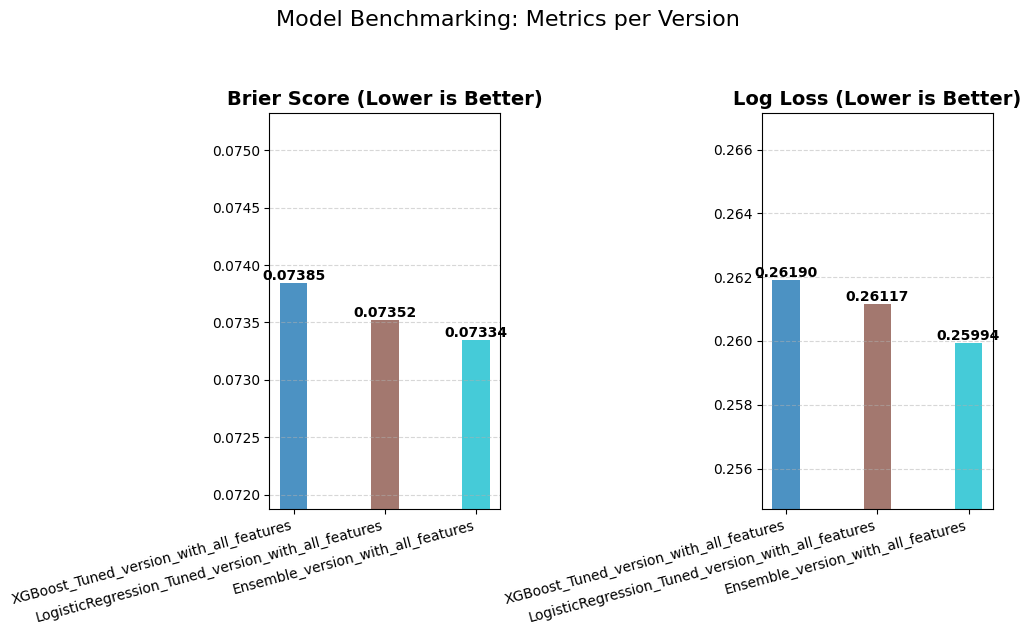

In [ ]:
# Brier Score & Log Loss
utils.plot_saved_performance_comparison()



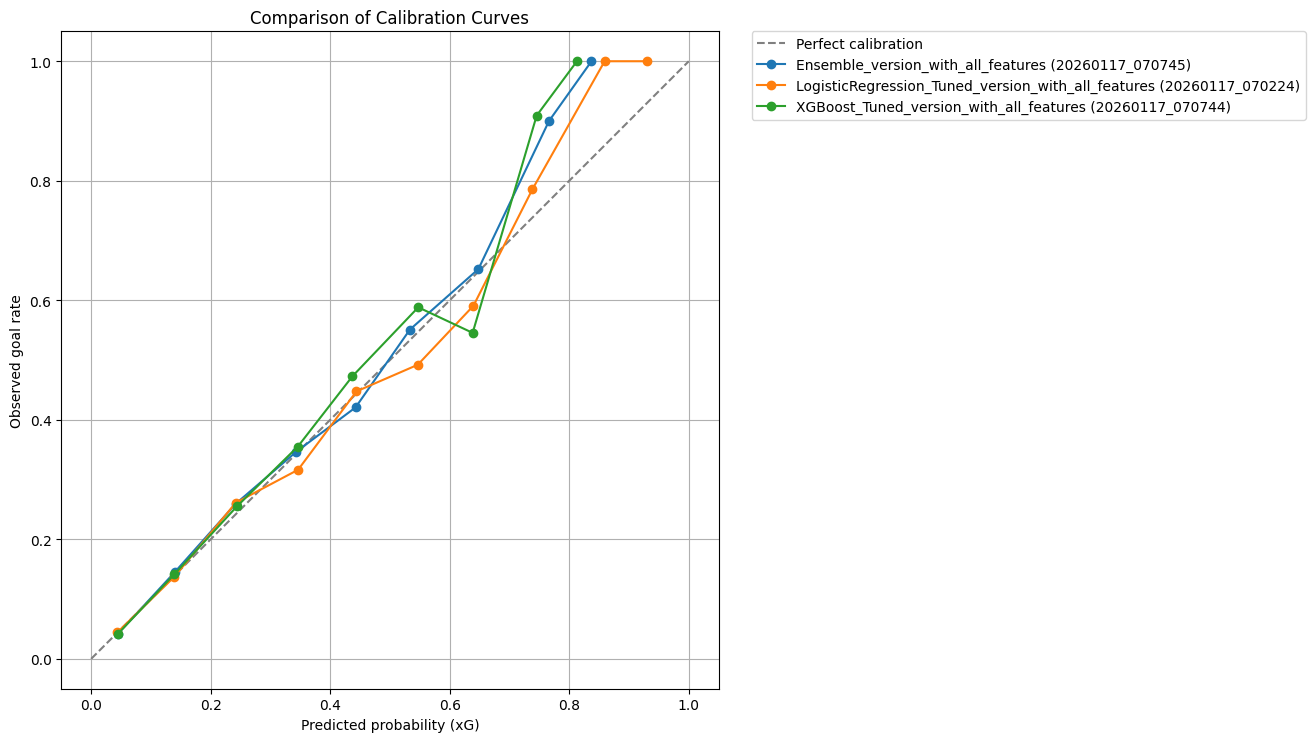

In [ ]:
# Calibration Curve
utils.compare_saved_experiments()



# Save Best Model



In [ ]:
# =================================================
# 🏆 Final Confirmed Version: Full Data Training & Ensemble Saving
# =================================================

# -------------------------------------------------
# Determine the optimal number of training iterations for XGBoost (Dry Run)
# When using all data, it is necessary to determine the optimal number of iterations
# and stop training accordingly to prevent overfitting.
# Therefore, determine the optimal training rounds first.
# -------------------------------------------------
# Temporarily split the data (90% training, 10% validation)
X_temp_train, X_temp_val, y_temp_train, y_temp_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Parameters (The best ones found by Optuna)
params_final = best_params_xgb.copy()
params_final['n_estimators'] = 10000 # Set a high number and rely on early stopping

# Add early_stopping_rounds to the parameters here
params_final['early_stopping_rounds'] = 50

print("📏 Measuring optimal XGBoost training rounds (Dry Run)...")

# early_stopping_rounds is applied during model definition
model_temp = xgb.XGBClassifier(**params_final)

# Do not include early_stopping_rounds in fit; only pass eval_set
model_temp.fit(
    X_temp_train, y_temp_train,
    eval_set=[(X_temp_val, y_temp_val)],
    verbose=False
)

# Get the optimal number of iterations
optimal_rounds = model_temp.best_iteration
print(f"✅ Dry run result: Optimal training rounds were {optimal_rounds}.")

# Add a slight margin (1.1x) as the data size increases to 100%
final_rounds = int(optimal_rounds * 1.1)
print(f"🎯 For full data training, training will be performed with {final_rounds} rounds.")



📏 Measuring optimal XGBoost training rounds (Dry Run)...
✅ Dry run result: Optimal training rounds were 181.
🎯 For full data training, training will be performed with 199 rounds.


In [ ]:
# -------------------------------------------------
# Final Production Training on All Data (XGBoost & Logistic Regression)
# -------------------------------------------------

# --- (A) XGBoost ---
params_final['n_estimators'] = final_rounds

# early_stopping is unnecessary for full data training, so remove it (set to None)
# This prevents potential errors stating "early_stopping is present without eval_set"
params_final['early_stopping_rounds'] = None

final_xgb_model = xgb.XGBClassifier(**params_final)
print(f"🚀 XGBoost: Training on all data for {final_rounds} rounds...")
final_xgb_model.fit(X, y)

# --- (B) Logistic Regression ---
# Also train Logistic Regression on all data (Standardization required)
print("🚀 Logistic Regression: Training on all data...")
final_scaler = StandardScaler()
X_scaled = final_scaler.fit_transform(X) # Fit on all data

final_lr_model = LogisticRegression(**best_params_lr) # Best parameters from full search
final_lr_model.fit(X_scaled, y)



🚀 XGBoost: Training on all data for 199 rounds...
🚀 Logistic Regression: Training on all data...


LogisticRegression(C=0.1553659150922986, max_iter=5000, n_jobs=-1, penalty='l1',
                   random_state=42, solver='saga')

In [ ]:
# -------------------------------------------------
# Definition of the Class for Saving & Saving
# -------------------------------------------------
class EnsembleXGModel:
    def __init__(self, xgb_model, lr_model, scaler, xgb_weight):
        self.xgb_model = xgb_model
        self.lr_model = lr_model
        self.scaler = scaler
        self.weight = xgb_weight
        self.feature_names_in_ = xgb_model.feature_names_in_
        self.classes_ = xgb_model.classes_

    def predict_proba(self, X):
        pred_xgb = self.xgb_model.predict_proba(X)[:, 1]
        X_scaled = self.scaler.transform(X) # transform only
        pred_lr = self.lr_model.predict_proba(X_scaled)[:, 1]
        final_pred = (self.weight * pred_xgb) + ((1 - self.weight) * pred_lr)
        return np.column_stack([1 - final_pred, final_pred])

# Instantiation (final_best_weight is the value determined earlier by Brier Score comparison)
final_ensemble_model = EnsembleXGModel(
    xgb_model=final_xgb_model,
    lr_model=final_lr_model,
    scaler=final_scaler,
    xgb_weight=final_best_weight  # Use the best weights obtained during ensemble learning
)



In [ ]:
model_save_path = 'models/best_xg_model.pkl'

if best_model_save:
    # Save the model
    with open(model_save_path, 'wb') as f:
        pickle.dump(final_ensemble_model, f)

    print(f"\n💾 Done! The final best model has been saved: {model_save_path}")
    print(f"   (Weight -> XGB: {final_best_weight:.2f}, LR: {1-final_best_weight:.2f})")


💾 Done! The final best model has been saved: model/best_xg_model.pkl
   (Weight -> XGB: 0.37, LR: 0.63)


# SHAP Values



In [ ]:
# =================================================
# Model Interpretation using SHAP Values
# =================================================

print("🤖 Starting SHAP value calculation...")

# 1. Create data for analysis
# Sampling 3000 cases randomly as using the full dataset (X) would take too much time
X_shap_analysis = X.sample(n=3000, random_state=42)
print(f"   Number of analysis targets: {X_shap_analysis.shape}")

# -------------------------------------------------
# 2. SHAP values for XGBoost
# -------------------------------------------------
explainer_xgb = shap.TreeExplainer(final_xgb_model)
shap_values_xgb = explainer_xgb(X_shap_analysis)

# -------------------------------------------------
# 3. SHAP values for Logistic Regression
# -------------------------------------------------
# LR requires scaled data, so we perform the transformation
X_shap_scaled = final_scaler.transform(X_shap_analysis)

# Simple LinearExplainer (passing average values as background data for better accuracy)
# Using default settings here prioritizing calculation speed
explainer_lr = shap.LinearExplainer(final_lr_model, X_shap_scaled, feature_perturbation="interventional")
shap_values_lr = explainer_lr(X_shap_scaled)

# -------------------------------------------------
# 4. Summing Ensemble SHAP values
# -------------------------------------------------
# Using the best weight determined in previous steps
w = final_best_weight

# Add weighted values and base values together
ensemble_values = (w * shap_values_xgb.values) + ((1 - w) * shap_values_lr.values)
ensemble_base_values = (w * shap_values_xgb.base_values) + ((1 - w) * shap_values_lr.base_values)

# Reassemble into a SHAP "Explanation" object
# Using original readable values (X_shap_analysis) for the data parameter
shap_values_ensemble = shap.Explanation(
    values=ensemble_values,
    base_values=ensemble_base_values,
    data=X_shap_analysis,
    feature_names=X.columns
)

print("✅ SHAP value calculation complete!")



🤖 Starting SHAP value calculation...
   Number of analysis targets: (3000, 45)
✅ SHAP value calculation complete!


/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [ ]:
ensemble_values.shape



(3000, 45)

In [ ]:
ensemble_values



array([[ 5.33748501e-03, -2.11351911e-03,  2.41843528e-02, ...,
        -3.71187491e-02,  1.04216932e-03, -6.60956011e-02],
       [ 6.38463800e-01,  2.50311977e-01, -1.49579799e-01, ...,
        -1.57249773e-01,  1.07547224e-03, -1.53694599e-01],
       [-1.88508230e+00, -4.02744258e-01,  2.61171772e-02, ...,
         6.70437624e-02,  6.77711418e-04,  8.31707243e-02],
       ...,
       [ 7.84251203e-01,  4.43793711e-01, -1.46072800e-01, ...,
        -3.92883562e-02,  7.57013704e-04, -9.35035104e-02],
       [ 6.89328315e-01,  2.96390970e-02,  3.46678691e-02, ...,
         7.17959830e-02,  5.61077958e-04,  9.99040108e-02],
       [ 5.96760285e-01,  2.12737046e-01,  2.91980810e-02, ...,
         7.35439834e-02,  1.17873999e-03,  1.27056519e-01]])

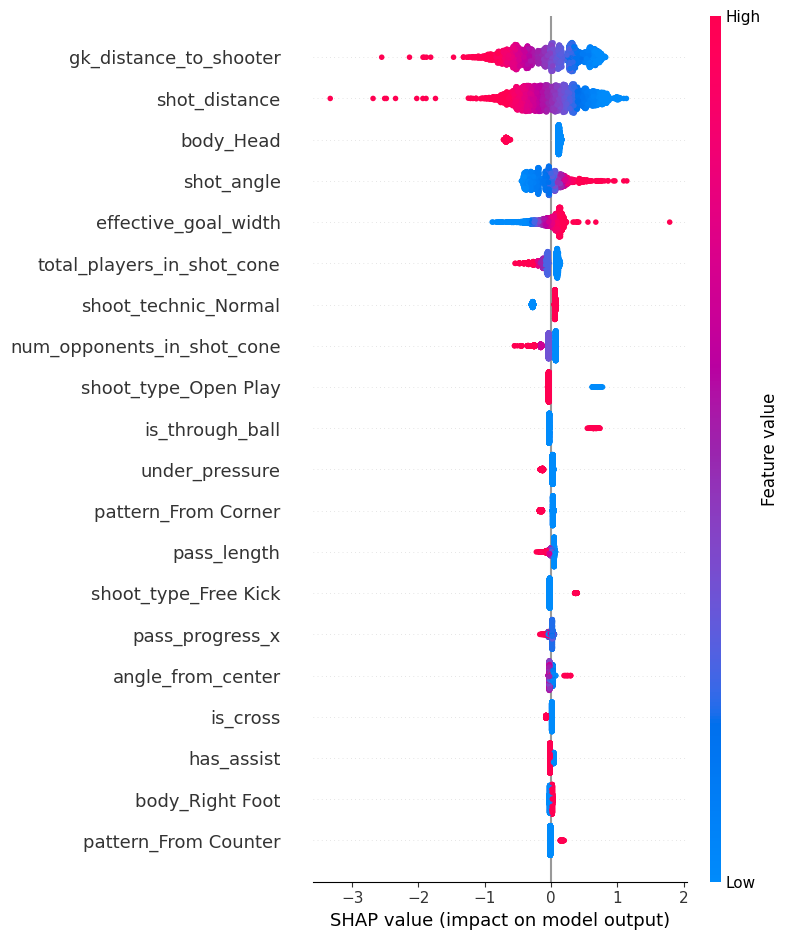

In [ ]:
# -------------------------------------------------
# 5. Visualization (Summary Plot)
# -------------------------------------------------
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_ensemble, X_shap_analysis, plot_type="dot")
plt.show()



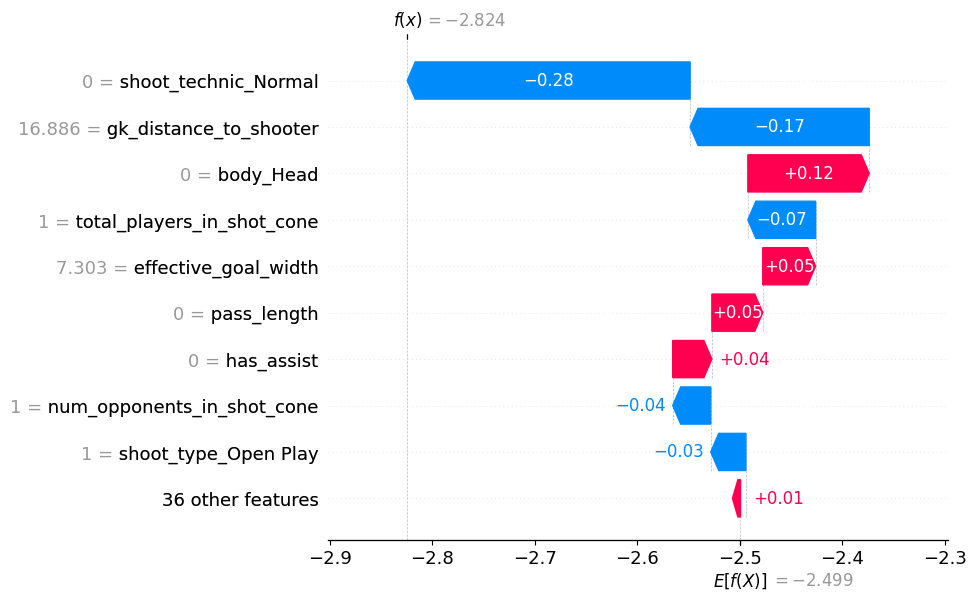

Actual Data (Index 0):
Goal: 0, Predicted Prob: 0.0190


In [ ]:
# Waterfall Plot (Analysis of individual shots)
# Ideal for analyzing specific shots (e.g., missed shots with high xG or goals with low xG)
# Example: Visualize the first record
# You can view any shot by changing the index
idx = 0

plt.figure(figsize=(8, 6))
shap.plots.waterfall(shap_values_ensemble[idx])
plt.show()

# Reference with actual data
print(f"Actual Data (Index {idx}):")
print(f"Goal: {y_val.iloc[idx]}, Predicted Prob: {final_xg[val_index][idx]:.4f}") # Note: Index alignment may need adjustment



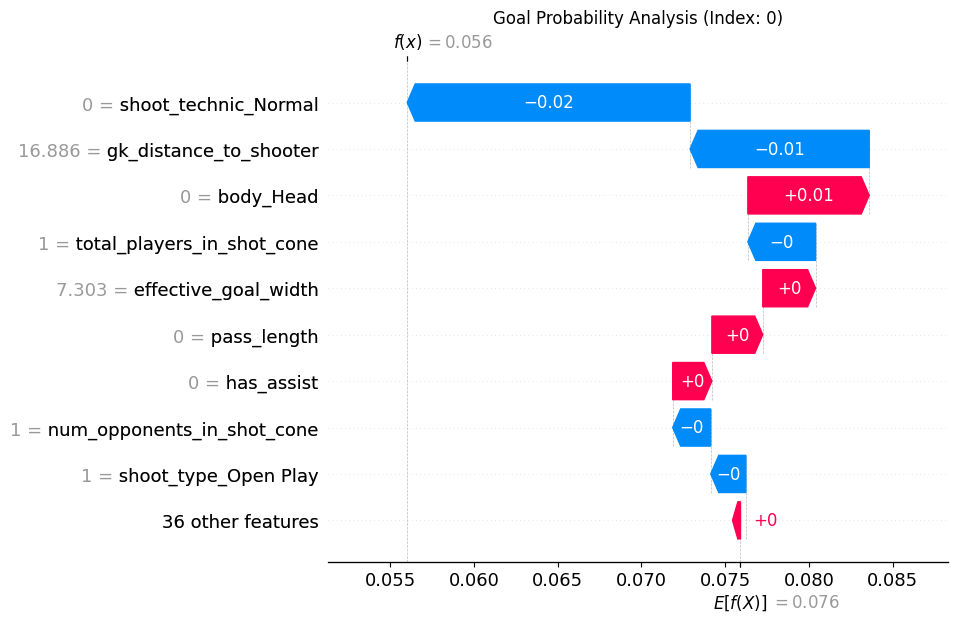

Original Predicted Probability: 0.0560
Baseline Probability: 0.0759


In [ ]:
# Sigmoid function (Logit -> Probability)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# ---------------------------------------------------------
# Reconstructing Ensemble SHAP object (Probability conversion version)
# ---------------------------------------------------------
# Note: This is not a strict "addition" but helps with intuitive understanding

# 1. Calculate baseline (average probability)
# Convert current base_values from logits to probabilities
prob_base_values = sigmoid(ensemble_base_values)

# 2. Approximate SHAP values as "contribution to probability"
# Simply treated as "probability differences" for visualization purposes

# First, calculate individual predicted probabilities
prob_values = sigmoid(ensemble_base_values + np.sum(ensemble_values, axis=1))

# Distribute contributions of each feature by ratio and assign to probability differences
# (Total Logit Diff) : (Total Prob Diff) = (Feature Logit) : (Feature Prob)
total_logit_diff = np.sum(ensemble_values, axis=1)
total_prob_diff = prob_values - prob_base_values

# Avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = total_prob_diff / total_logit_diff
    ratio[np.isnan(ratio)] = 0 # Set to 0 if there is no change

# Multiply using broadcasting
prob_shap_values = ensemble_values * ratio[:, np.newaxis]

# ---------------------------------------------------------
# 3. Create a new Explanation object
# ---------------------------------------------------------
shap_values_prob = shap.Explanation(
    values=prob_shap_values,
    base_values=prob_base_values,
    data=X_shap_analysis,
    feature_names=X.columns
)

# ---------------------------------------------------------
# 4. Plot (This sets the unit to "probability (0.0~1.0)")
# ---------------------------------------------------------
idx = 0 # Index of the data to view

plt.figure(figsize=(8, 6))
# Setting axis format to percentage is even better
shap.plots.waterfall(shap_values_prob[idx], max_display=10, show=False)
plt.title(f"Goal Probability Analysis (Index: {idx})")
plt.show()

print(f"Original Predicted Probability: {prob_values[idx]:.4f}")
print(f"Baseline Probability: {prob_base_values[idx]:.4f}")



# Create and Save Dataframe for Tactical Analysis



In [ ]:
# Safety checks
assert len(df) == len(final_xg), "Error: Row counts of df and final_xg do not match!"
assert all_league_shots_df is not None, "Error: all_league_shots_df is not in memory!"

# Use the df containing prediction results as a base
df_analysis = df.copy()

# Assign final_xg (Ensemble)
df_analysis["xg"] = final_xg

# 【Important】 Restore "readable columns" that disappeared from the original dataframe
# all_league_shots_df is the raw data loaded at the beginning of the notebook
# Since it has the same index as df_analysis, we can extract it using .loc

restore_cols = [
    "shot_outcome_name",
    "shot_type_name",
    "play_pattern_name",
    "shot_body_part_name",
    "shot_technique_name"
]

# Extract rows from the original data that match the current training data (df)
# Assumes all_league_shots_df is still in memory
df_original_cols = all_league_shots_df.loc[df_analysis.index, restore_cols]

# Join (overwrite) the restored columns to df_analysis
for col in restore_cols:
    df_analysis[col] = df_original_cols[col]

# Select columns to save
# (Basic info + Restored info + Created features + xG)
output_cols = [
    # ID and Time (these should still be present)
    "match_id", "id", "period", "minute", "second",
    "team_name", "player_name", "position_name",
    "x", "y",

    # Restored readable columns
    "shot_outcome_name", "shot_type_name", "play_pattern_name", "shot_body_part_name","shot_technique_name",

    # Outcome and Prediction
    "is_goal", "xg"
]

# Add feature list (for analysis: numerical data)
output_cols = output_cols + FEATURES

# Remove duplicates
output_cols = list(dict.fromkeys(output_cols))

# Create save dataframe by selecting only existing columns
exist_cols = [c for c in output_cols if c in df_analysis.columns]
df_save = df_analysis[exist_cols]

# Save
SAVE_PATH = "data/pl_scored_dataset.csv"
df_save.to_csv(SAVE_PATH, index=False)

print(f"💾 Analysis dataset saved: {SAVE_PATH}")
print(f"📝 Number of columns saved: {len(df_save.columns)}")
print("✅ Ensemble prediction values (final_xg) have been saved!")



💾 Analysis dataset saved: data/pl_scored_dataset.csv
📝 Number of columns saved: 62
✅ Ensemble prediction values (final_xg) have been saved!


In [ ]:
df_save.columns

Index(['match_id', 'id', 'period', 'minute', 'second', 'team_name',
       'player_name', 'position_name', 'x', 'y', 'shot_outcome_name',
       'shot_type_name', 'play_pattern_name', 'shot_body_part_name',
       'shot_technique_name', 'is_goal', 'xg', 'shot_distance', 'shot_angle',
       'under_pressure', 'body_Head', 'body_Left Foot', 'body_Other',
       'body_Right Foot', 'shoot_type_Corner', 'shoot_type_Free Kick',
       'shoot_type_Open Play', 'pattern_From Corner', 'pattern_From Counter',
       'pattern_From Free Kick', 'pattern_From Goal Kick',
       'pattern_From Keeper', 'pattern_From Kick Off', 'pattern_From Throw In',
       'pattern_Other', 'pattern_Regular Play', 'shoot_technic_Backheel',
       'shoot_technic_Diving Header', 'shoot_technic_Half Volley',
       'shoot_technic_Lob', 'shoot_technic_Normal',
       'shoot_technic_Overhead Kick', 'shoot_technic_Volley',
       'effective_goal_width', 'angle_from_center', 'in_penalty_area',
       'in_six_yard_box', 'dist